In [41]:
import sklearn
import pandas as pd

In [42]:
import pickle

with open('../yk_dataframes.pkl', 'rb') as file:
    data = pickle.load(file)

yk_full = data['yk_full']
yk_dropped = data['yk_dropped']

with open('../ty_dataframes.pkl', 'rb') as file:
    data = pickle.load(file)

ty_full = data['ty_full']
ty_dropped = data['ty_dropped']


with open('../luna_dataframes.pkl', 'rb') as file:
    data = pickle.load(file)

luna_full = data['luna_full']
luna_dropped = data['luna_dropped']

In [43]:
luna_full_filled = luna_full.fillna(0)

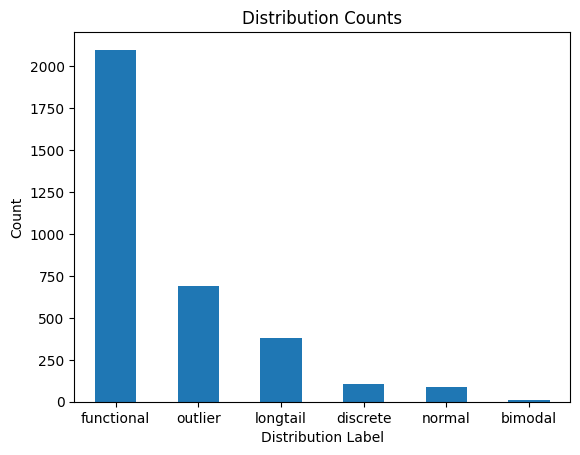

In [44]:
distribution_counts = luna_full_filled['Distribution Type'].value_counts()

import matplotlib.pyplot as plt

distribution_counts.plot(kind='bar')
plt.title('Distribution Counts')
plt.xlabel('Distribution Label')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

In [45]:
from sklearn.model_selection import train_test_split

columns_to_drop = ['Target', 'Name', 'Distribution Type', 'Target_Encoded']
X = luna_full_filled.drop(columns = columns_to_drop)
y = luna_full_filled['Target_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [47]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9718100890207715
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       468
           1       0.95      0.96      0.95       206

    accuracy                           0.97       674
   macro avg       0.97      0.97      0.97       674
weighted avg       0.97      0.97      0.97       674



In [15]:
y.value_counts()

Target_Encoded
0    2300
1    1070
Name: count, dtype: int64

In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [55]:
model_smote = RandomForestClassifier() # class_weight={0: 1, 1: 10}
model_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(X_test)
y_pred_smote_adjusted = (model_smote.predict_proba(X_test)[:, 1] >= 0.73).astype(int) # f1_threshold calculated below

In [56]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))

Accuracy: 0.9762611275964391
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       468
           1       0.95      0.98      0.96       206

    accuracy                           0.98       674
   macro avg       0.97      0.98      0.97       674
weighted avg       0.98      0.98      0.98       674



In [57]:
import pickle

with open('luna_only_model.pkl', 'wb') as file:
    pickle.dump(model_smote, file)

In [60]:
params = model_smote.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
for i, tree in enumerate(model_smote.estimators_):
    depth = tree.get_depth()
    size = tree.tree_.node_count  # Number of nodes in the tree
    #features = tree.tree_.feature
    print(f"Tree {i}: Depth = {depth}, Size = {size}")
    #print(features)

In [72]:
for i, tree in enumerate(model_smote.estimators_):
    depth = tree.get_depth()
    size = tree.tree_.node_count  

    features = tree.tree_.feature

    print(f"Tree {i}: Depth = {depth}, Size = {size}")

    # Map feature indices to feature names
    feature_names = [X_train_smote.columns[i] if i != -1 else 'Leaf Node' for i in features]

    df = pd.DataFrame({
        'Node Index': range(len(features)),
        'Feature Index': features,
        'Feature Name': feature_names
    })

    print(df.head())
    #print() 

Tree 0: Depth = 9, Size = 121
   Node Index  Feature Index          Feature Name
0           0             29          Outliers_IQR
1           1             21     Tail_Weight_Ratio
2           2             25                   P99
3           3             22  Tail_Length_Ratio_95
4           4             -2          Shapiro_Stat
Tree 1: Depth = 11, Size = 115
   Node Index  Feature Index  Feature Name
0           0              2          Mean
1           1             -2  Shapiro_Stat
2           2             36  Shapiro_Stat
3           3              7      Kurtosis
4           4              5           IQR
Tree 2: Depth = 15, Size = 107
   Node Index  Feature Index     Feature Name
0           0              1     Unique_Count
1           1             -2     Shapiro_Stat
2           2             13  Extreme_Tail_95
3           3              2             Mean
4           4              4          Std_Dev
Tree 3: Depth = 13, Size = 133
   Node Index  Feature Index     Feat

In [63]:
depths = [tree.get_depth() for tree in model_smote.estimators_]
sizes = [tree.tree_.node_count for tree in model_smote.estimators_]

average_depth = np.mean(depths)
average_size = np.mean(sizes)

print(f"Average Depth: {average_depth}")
print(f"Average Size: {average_size}")

Average Depth: 12.84
Average Size: 119.74


In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=model_smote, param_grid=param_grid, cv=3, n_jobs=-1, verbose=False)
grid_search.fit(X_train_smote, y_train_smote)

print(grid_search.best_params_)


{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [74]:
tuned_model = RandomForestClassifier(**grid_search.best_params_)
tuned_model.fit(X_train_smote, y_train_smote)
tuned_pred = tuned_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, tuned_pred))
print("Classification Report:\n", classification_report(y_test, tuned_pred))

Accuracy: 0.9718100890207715
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       468
           1       0.94      0.97      0.95       206

    accuracy                           0.97       674
   macro avg       0.96      0.97      0.97       674
weighted avg       0.97      0.97      0.97       674



In [19]:
y_pred_smote_adjusted = (model_smote.predict_proba(X_test)[:, 1] >= 0.59).astype(int) # f1_threshold calculated below

In [20]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_smote_adjusted))
print("Classification Report:\n", classification_report(y_test, y_pred_smote_adjusted))

Accuracy: 0.9747774480712166
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       468
           1       0.95      0.97      0.96       206

    accuracy                           0.97       674
   macro avg       0.97      0.97      0.97       674
weighted avg       0.97      0.97      0.97       674



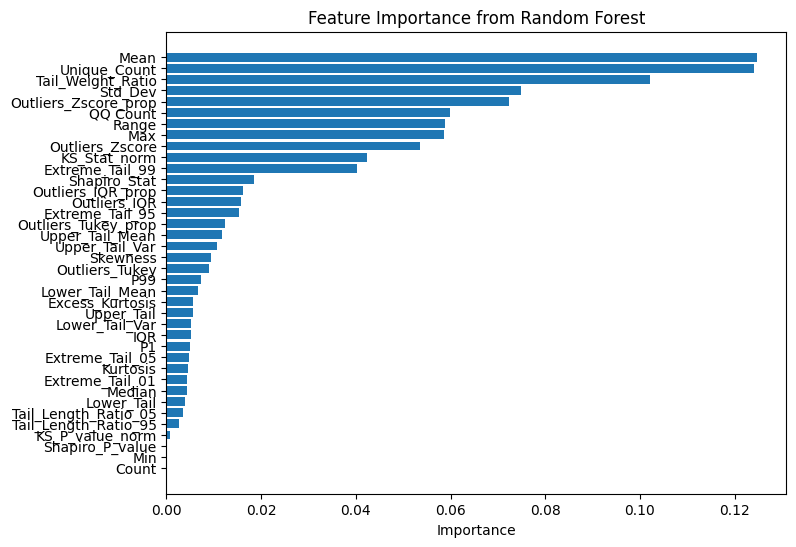

In [61]:
import pandas as pd
import matplotlib as plt

importances = model_smote.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

# Ranking predictions based on confidence

(array([  9.,   3.,   1.,   0.,   1.,   3.,   6.,   1.,   2., 180.]),
 array([0.04337223, 0.13903501, 0.23469779, 0.33036056, 0.42602334,
        0.52168612, 0.61734889, 0.71301167, 0.80867445, 0.90433722,
        1.        ]),
 <BarContainer object of 10 artists>)

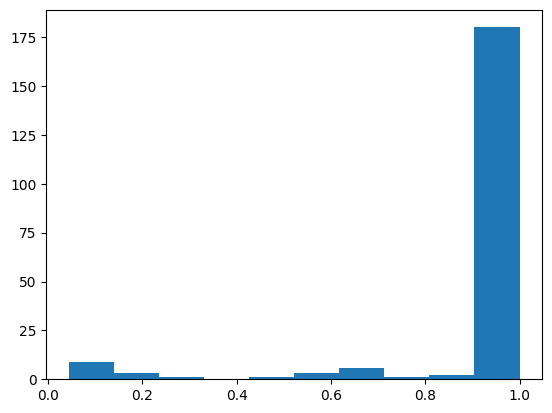

In [92]:
probs = model_smote.predict_proba(X_test)[:, 1] 

test_with_probs = pd.DataFrame(X_test.copy())
test_with_probs['Prediction Prob'] = probs
test_with_probs['True Label'] = y_test

positive_class = test_with_probs[test_with_probs['True Label'] == 1]
negative_class = test_with_probs[test_with_probs['True Label'] == 0]

positive_sorted = positive_class.sort_values(by='Prediction Prob', ascending=False)
negative_sorted = negative_class.sort_values(by='Prediction Prob', ascending=False)

plt.hist(positive_sorted['Prediction Prob'])

## Joining test details for identification

In [99]:
columns = positive_sorted.columns.tolist()
new_order = columns[-2:] + columns[:-2] 
positive_sorted = positive_sorted[new_order]

details_df = luna_full_filled[['Name', 'Distribution Type']]

positive_merged = details_df.join(positive_sorted, how='inner')  # join on the row index
positive_sorted_df = positive_merged.reindex(positive_sorted.index)
#positive_sorted_merged = pd.merge(details_df, positive_sorted, left_index=True, right_index=True, how='inner') 
positive_sorted_df

,Name,Distribution Type,Prediction Prob,True Label,Count,Unique_Count,Mean,Median,Std_Dev,IQR,...,Outliers_Zscore_prop,Outliers_IQR,Outliers_IQR_prop,Outliers_Tukey,Outliers_Tukey_prop,QQ Count,KS_Stat_norm,KS_P_value_norm,Shapiro_Stat,Shapiro_P_value
2998,f_nvmXReadPatall0Rdtypemrg0seNvm1_x_x_vhsform_...,longtail,1.000000,1,10743,11,0.038837,0.000000,0.067891,0.076923,...,0.013683,3648,0.339570,51,0.004747,314,0.376797,0.000000e+00,0.615353,3.972241e-93
2943,f_nvmXReadPatdatalogRepairRegsRdtyperdRrepairN...,outlier,1.000000,1,10743,28,0.002407,0.000000,0.047974,0.000000,...,0.002513,27,0.002513,27,0.002513,54,0.517494,0.000000e+00,0.024361,1.092808e-116
1102,p_iddq_SE-IDDQ-Pre__SE_ScanProdIddq_iddq_VDDC_p47,outlier,1.000000,1,10744,9204,0.076792,0.074381,0.034502,0.039904,...,0.007353,10743,0.999907,17,0.001582,72,0.056053,8.790519e-30,0.872303,1.034168e-68
2418,f_nvmXReadPatdistCkbdRdtypedistAsrNvm1_x_x_vnv...,longtail,1.000000,1,10743,10678,0.775255,0.802541,0.136867,0.173145,...,0.012752,0,0.000000,21,0.001955,486,0.082201,1.358071e-63,0.925352,3.421627e-58
1161,p_iddq_SE-IDDQ-Post__SE_ScanProdIddq_iddq_VDDC...,outlier,1.000000,1,10743,9178,0.073888,0.071228,0.034131,0.039305,...,0.007074,10742,0.999907,17,0.001582,68,0.056269,5.241019e-30,0.866553,1.299857e-69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,f_nvmXWritePatall1IfrNvm0_x_x_vhsform__nvm0_FU...,outlier,0.043372,1,10743,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.000000,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1563,f_bfXmod.POWER_NVM__NFC-HFO-TRIM-DFT,outlier,0.043372,1,10743,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.000000,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1985,f_nvmXReadPatall0Rdtypemrg0bCrepairNvm0_x_x_vh...,outlier,0.043372,1,10743,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.000000,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1922,f_nvmXReadPatdatalogRepairRegsRdtyperdRrepairN...,outlier,0.043372,1,10743,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.000000,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00


In [110]:
positive_sorted_df[positive_sorted_df['Prediction Prob'] > 0.5]['Tail_Weight_Ratio']

0.042888690961127934

In [117]:
positive_sorted_df[positive_sorted_df['Prediction Prob'] < 0.5]

,Name,Distribution Type,Prediction Prob,True Label,Count,Unique_Count,Mean,Median,Std_Dev,IQR,...,Outliers_Zscore_prop,Outliers_IQR,Outliers_IQR_prop,Outliers_Tukey,Outliers_Tukey_prop,QQ Count,KS_Stat_norm,KS_P_value_norm,Shapiro_Stat,Shapiro_P_value
1494,a_clkXRINGO_NFC_x_VBAT3V6__cln28_stdro_hs28_lu...,longtail,0.320000,1,10743,59,0.441821,0.435484,0.122261,0.161290,...,0.002979,10743,1.0,1,0.000093,62,0.030584,3.649585e-09,0.998051,1.906861e-10
17,p_openXend_PAD_x_500uA__VDDIO,longtail,0.220000,1,10744,7432,0.580815,0.601983,0.199211,0.279821,...,0.000000,0,0.0,0,0.000000,314,0.045514,8.867120e-20,0.981004,1.938186e-35
1501,a_clkXRINGO_NFC_x_VBAT3V6__cln28_stdro_hs28_lu...,longtail,0.210000,1,10743,62,0.430486,0.421875,0.124873,0.171875,...,0.002979,10743,1.0,0,0.000000,192,0.040483,9.800459e-16,0.997289,4.450919e-13
2714,f_nvmXTrimPatvchNvm1_x_x_vlsvls__PAR,outlier,0.200000,1,10743,9939,0.453574,0.451315,0.130545,0.175960,...,0.002420,10743,1.0,0,0.000000,596,0.007137,6.418175e-01,0.999507,4.992702e-03
1860,f_nvmXReadPatall0Rdtypemrg0aRedenCrepairNvm0_x...,outlier,0.043372,1,10743,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
2249,f_nvmXWritePatall1RdtyperdNvm0_x_x_vhsform__nv...,outlier,0.043372,1,10743,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1991,f_nvmXReadPatdatalogRepairRegsRdtyperdCrepairN...,outlier,0.043372,1,10743,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
2646,f_nvmXReadPatall0Rdtypemrg0cRrepairNvm1_x_x_vh...,outlier,0.043372,1,10743,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
2245,f_nvmXWritePatall1IfrNvm0_x_x_vhsform__nvm0_FU...,outlier,0.043372,1,10743,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1563,f_bfXmod.POWER_NVM__NFC-HFO-TRIM-DFT,outlier,0.043372,1,10743,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00


# Analysis of unrecalled points

In [49]:
y_pred_all = model_smote.predict(X)

unrecalled_mask = (y == 1) & (y_pred_all != 1)
unrecalled_points = X[unrecalled_mask]

recalled_mask = (y == 1) & (y_pred_all == 1)
recalled_points = X[recalled_mask]

unrecalled_points.index

Index([  17, 1494, 1501, 1563, 1780, 1782, 1783, 1860, 1862, 1867, 1922, 1983,
       1985, 1990, 1991, 2057, 2059, 2060, 2133, 2134, 2245, 2249, 2261, 2262,
       2334, 2630, 2646, 2648, 2657, 2690, 2699, 2714, 2909],
      dtype='int64')

# Calculating threshold to maximize f1 score

In [22]:
from sklearn.metrics import precision_recall_curve
import numpy as np

y_probs = model_smote.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# best threshold for recall
recall_idx = np.argmax(recalls)
recall_threshold = thresholds[recall_idx]

# best threshld for f1 score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_idx = np.argmax(f1_scores)
f1_threshold = thresholds[f1_idx]

print(f1_threshold)

0.73


# Predict on yk data

In [54]:
yk_full_filled = yk_full.fillna(0)

In [55]:
columns_to_drop = ['Target', 'Name', 'Distribution Type', 'Target_Encoded']
X_yk = yk_full_filled.drop(columns = columns_to_drop)
y_yk = yk_full_filled['Target_Encoded']

In [59]:
y_pred_yk = model_smote.predict(X_yk)
y_pred_yk_adjusted = (model_smote.predict_proba(X_yk)[:, 1] >= 0.38).astype(int)

In [57]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_yk, y_pred_yk))
print("Classification Report:\n", classification_report(y_yk, y_pred_yk))

Accuracy: 0.8117073170731708
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.78       490
           1       0.78      0.90      0.83       535

    accuracy                           0.81      1025
   macro avg       0.82      0.81      0.81      1025
weighted avg       0.82      0.81      0.81      1025



In [60]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_yk, y_pred_yk_adjusted))
print("Classification Report:\n", classification_report(y_yk, y_pred_yk_adjusted))

Accuracy: 0.7482926829268293
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.49      0.65       490
           1       0.68      0.99      0.80       535

    accuracy                           0.75      1025
   macro avg       0.82      0.74      0.73      1025
weighted avg       0.82      0.75      0.73      1025



# Predict on TY data

In [61]:
ty_full_filled = ty_full.fillna(0)

In [62]:
columns_to_drop = ['Target', 'Name', 'Distribution Type', 'Target_Encoded']
X_ty = ty_full_filled.drop(columns = columns_to_drop)
y_ty = ty_full_filled['Target_Encoded']

In [63]:
y_pred_ty = model_smote.predict(X_ty)
y_pred_ty_adjusted = (model_smote.predict_proba(X_ty)[:, 1] >= 0.38).astype(int)

In [64]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_ty, y_pred_ty))
print("Classification Report:\n", classification_report(y_ty, y_pred_ty))

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_ty, y_pred_ty_adjusted))
print("Classification Report:\n", classification_report(y_ty, y_pred_ty_adjusted))

Accuracy: 0.5221112696148359
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.46      0.63      1239
           1       0.19      0.97      0.32       163

    accuracy                           0.52      1402
   macro avg       0.59      0.72      0.48      1402
weighted avg       0.90      0.52      0.60      1402

Accuracy: 0.4044222539229672
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.49      1239
           1       0.16      1.00      0.28       163

    accuracy                           0.40      1402
   macro avg       0.58      0.66      0.39      1402
weighted avg       0.90      0.40      0.47      1402

